In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from final_processing import final_processing_functions as fpf
import pathlib
from matplotlib import pyplot as plt
import seaborn as sb
import warnings
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import rcParams
import yaml
import figure_formatting as ff
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import pearsonr
import matplotlib
warnings.filterwarnings('ignore')
from final_processing import loading_functions as lf
import final_processing.MAPseq_data_processing as mdp
import statsmodels.formula.api as smf
%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/camp/home/turnerb/.conda/envs/

Load filepaths and perform area assignment

In [2]:
gen_parameters = lf.load_gen_params()
mice = gen_parameters['MICE']
saving_path = gen_parameters['fig_saving_path']
proj_path = gen_parameters['proj_path']
ff.set_font_params(gen_parameters)


In [42]:
#load all mice neuron projection datasets
combined_dict = mdp.samples_to_areas(mice = mice, proj_path=proj_path)
all_mice_combined = pd.concat([
    combined_dict[k]['homogenous_across_cubelet'][mdp.get_common_columns(mice=mice, combined_dict=combined_dict, cortex=True)]
    for k in mice
])

Fig 2b-c

KS =0.20 (p=0.71), r =0.79 (p=2.3e-06)
KS =0.24 (p=0.475), r =0.73 (p=4e-05)


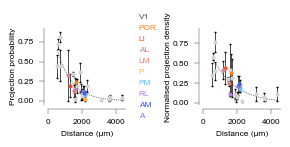

In [43]:
freq_df, freq_df_strength, distances = mdp.get_distances_from_A1(combined_dict= combined_dict, area_cols=all_mice_combined.columns, mice =mice)
font_size=gen_parameters['font_size']
fig, axes = plt.subplots(1, 2, figsize=(3, 1))
plt.subplots_adjust(wspace=1)
for which_ax, df in zip(axes, [freq_df, freq_df_strength]):
    means, errors = mdp.get_means_errors(df)
    if (len(distances) > 1 and (means > 0).any()
            and not distances.isna().any() and not means.isna().any()):
        fit = mdp.fit_exponential(distances, means)
        ff.plot_exponential_fit(which_ax, fit)
        print(f"KS ={fit.ks_stat:.2f} (p={fit.ks_p:.3g}), "
                f"r ={fit.cv_corr:.2f} (p={fit.cv_p:.3g})")
    ff.plot_errorbars(which_ax, distances, means, errors, color_map=ff.get_colour_dict(allen_nomenclature=True))
    ff.myPlotSettings_splitAxis(fig=fig, ax=which_ax, ytitle= '', xtitle='Distance (µm)', title='', mySize =font_size)
ff.style_figure_exp_fits(fig, axes, color_map=ff.get_colour_dict(allen_nomenclature=True), convert_dict=ff.get_convert_dict(), font_size=font_size)
fig.savefig(f"{saving_path}/fig2_dist_vs_proj.pdf", format="pdf")
fig.savefig(f"{saving_path}/fig2_dist_vs_proj.svg", format="svg")


Fig. 2e

In [32]:
AP_position_dict_list_combined, AP_soma_VC_sample = mdp.compute_mean_soma_AP_positions(gen_parameters=gen_parameters)

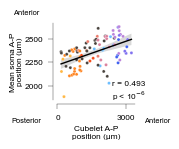

In [25]:
convert_dict = ff.get_convert_dict()
which_colour = ff.get_colour_dict(allen_nomenclature=True)
AP_soma_VC_sample['converted'] = AP_soma_VC_sample['VC_majority'].map(convert_dict)
which_colour_other = ff.get_colour_dict(allen_nomenclature=False)
rho, pval = pearsonr(AP_soma_VC_sample['AP_Vis'], AP_soma_VC_sample['mean_AP_soma'])
font_size = gen_parameters['font_size']
fig, ax = plt.subplots(figsize=(1, 1)) 
sb.regplot(
    x='AP_Vis',
    y='mean_AP_soma',
    data=AP_soma_VC_sample, color='black', scatter=False,
    ci=95, scatter_kws={'s':5}, line_kws={'linewidth':1}
)
scatter = sb.scatterplot(
    x='AP_Vis', 
    y='mean_AP_soma', 
    data=AP_soma_VC_sample, 
    hue='converted', legend=False,
    palette=which_colour_other, 
    s=5  
)
handles, labels = scatter.get_legend_handles_labels()

symbol_add, exp_add = ff.convert_to_exp(num=pval)
add_text = f"r = {rho:.3f}\np {symbol_add} 10$^{{{exp_add}}}$"
plt.text(
    0.7, 0.25,
    add_text,
    ha='left',
    va='top',
    transform=plt.gca().transAxes,
    fontsize=gen_parameters['font_size'],
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0)
)
xlabel = 'Cubelet A-P\nposition (µm)'
ylabel = 'Mean soma A-P\nposition (µm)'
plt.text(1.45, -0.3, 'Anterior', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=gen_parameters['font_size']*0.9)
plt.text(-0.4, 1.1, 'Anterior', ha='center', va='bottom', transform=plt.gca().transAxes, fontsize=gen_parameters['font_size']*0.9)
plt.text(-0.4, -0.3, 'Posterior', transform=plt.gca().transAxes, fontsize=gen_parameters['font_size']*0.9, va='bottom', ha='center')
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= ylabel, xtitle=xlabel, title='', mySize =gen_parameters['font_size'])

plt.xticks([0, 3000])
fig.savefig(f"{gen_parameters['fig_saving_path']}/fig_2_AP_vs_VISAP.svg", format="svg")
fig.savefig(f"{gen_parameters['fig_saving_path']}/fig_2_AP_vs_VISAP.pdf", format="pdf")


Fig. 2f

In [30]:
where_AP_vis, area_AP_dict = mdp.get_area_mean_AP(gen_parameters=gen_parameters, combined_dict=combined_dict, AP_position_dict_list_combined=AP_position_dict_list_combined)

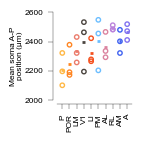

In [31]:
convert_dict = ff.get_convert_dict()
keys_sorted = sorted(
    area_AP_dict.keys(),
    key=lambda k: where_AP_vis[k]  
)

fig, ax = plt.subplots(figsize=(1.4, 1.4))

for i, key in enumerate(keys_sorted):
    positions = area_AP_dict[key]
    values = [val*25 for val in positions]
    color = which_colour[key]
    
    xvals = np.full(len(values), i) 
    ax.scatter(
        xvals, values,
        marker='o',
        facecolors='none',
        edgecolors=color,
        s=10,
        label=key
    )
    
    mean_val = np.mean(values)
    ax.hlines(
        y=mean_val,
        xmin=i - 0.2,
        xmax=i + 0.2,
        colors=color,
        linewidth=2
    )


converted_labels = [convert_dict.get(k, k) for k in keys_sorted]
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= '', xtitle='', title='', mySize =gen_parameters['font_size'])
ax.set_xticks(range(len(keys_sorted)))
ax.set_xticklabels(converted_labels, rotation=90, size=gen_parameters['font_size'])
ax.set_ylabel("Mean soma A-P\nposition (µm)", size=gen_parameters['font_size'])
ax.set_ylim(bottom=2000, top=2600)
plt.tight_layout()
fig.savefig(f"{saving_path}/fig2_meanAP_pos_area.svg", format="svg")
fig.savefig(f"{saving_path}/fig2_meanAP_pos_area.pdf", format="pdf")
plt.show()


Fig. 2g

p value for VISam is 0.014
p value for VISrl is 1.8e-22
p value for VISpor is 4.2e-28
p value for VISpl is 4.2e-10


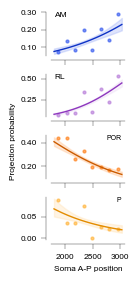

In [63]:
# here we plot individual probabilities. Note, we use mice as a fixed effect to calculate p-values, but logistic regression on all the dataset binned is performed for visualisaiton of plots

pval_df, df, results_popuplation_dict = mdp.individual_area_probabilities(gen_parameters=gen_parameters, combined_dict=combined_dict, AP_position_dict_list_combined=AP_position_dict_list_combined)
convert_dict = ff.get_convert_dict()
HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
num_bins = 8

fig, axes = plt.subplots(
    nrows=4,          
    ncols=1,        
    figsize=(1.4, 2.8),
    sharex=True       
)
axes = axes.flatten() 

for idx, (ax, area) in enumerate(zip(axes, areas_to_plot)):
    model = results_popuplation_dict[area]
    main_color = HVA_colors_updated.get(area, 'black')
    fit_color = ff.adjust_color(main_color, 0.7)
    ci_color  = ff.adjust_color(main_color, 1.3)

    df_area = df[df['Area'] == area].copy()
    ap_vals = df_area['AP_position'].values
    proj_vals = df_area['Projection'].values
    bin_edges = np.linspace(ap_vals.min(), ap_vals.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_proportions = []
    for i in range(num_bins):
        in_bin = (ap_vals >= bin_edges[i]) & (ap_vals < bin_edges[i+1])
        if np.sum(in_bin) > 0:
            bin_proportions.append(proj_vals[in_bin].mean())
        else:
            bin_proportions.append(np.nan)
    
    valid = ~np.isnan(bin_proportions)
    ax.plot(bin_centers[valid],
            np.array(bin_proportions)[valid],
            'o',
            label='Binned data',
            color=main_color, markersize=2,
            alpha=0.7)

    ap_grid = np.linspace(ap_vals.min(), ap_vals.max(), 100)
    new_data = pd.DataFrame({'AP_position': ap_grid})
    
    pred = model.get_prediction(new_data)
    pred_df = pred.summary_frame(alpha=0.05)
    yhat  = pred_df['predicted']
    lower = pred_df['ci_lower']
    upper = pred_df['ci_upper']
    
    ax.plot(ap_grid, yhat, '-', color=fit_color, linewidth=1)
    ax.fill_between(ap_grid, lower, upper, color=ci_color, alpha=0.3)

    ff.myPlotSettings_splitAxis(
        fig=fig,
        ax=ax,
        ytitle="",                             
        xtitle="Soma A-P position" if idx == len(axes)-1 else "",
        title="",
        axisColor='k',
        mySize=font_size
    )
    
    p_corrected = pval_df.loc[area, 'p_value_corrected']
    print (f'p value for {area} is {p_corrected:.2g}')
    if idx < 2:
        ax.text(0.05, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='left', va='top',
                fontsize=font_size, color='black')
    else:
        ax.text(0.95, 1, f"{convert_dict[area]}",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=5, color='black')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xticks([2000, 2500, 3000])
fig.supylabel('Projection probability',                    
            fontsize=font_size,
            x=0.1)   
plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.svg", format="svg")
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.pdf", format="pdf")
